
<div align="center">
    <h2>Nadiia Gorash</h2>
    <h5>interview at Bumble</h5>
    <img src="./images/bumble.png" alt="bumble" width = 400/> 
</div>



Using the attached dataset, please create a notebook (preferably Python but any tool is allowed) to explore the data in order to answer questions like:
+ **How would you make a geo expansion recommendation?**
+ **What new columns would you create?**
+ **How might clustering analysis help - how would you go about it?**

However, use these questions just as a starting point, and feel free to also use your own creativity/inspiration

In the interview process, we'll ask you to take us through your notebook, thought process and the libraries that you've used. A presentation/deck of any kind is not necessary.

[Metadata](https://carto.com/spatial-data-catalog/browser/dataset/acs_sociodemogr_f7ba0b77/data)

Accnowledgements :
    
This work is based on the [geographicdata.science](https://geographicdata.science/)

In [21]:
import pandas as pd 
import numpy as np
import seaborn as sns
import contextily as ctx

import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn import cluster
import libpysal
from esda.moran import Moran
from libpysal.weights import Queen, KNN
from sklearn import metrics

In [22]:

#loading provided dataset
df = pd.read_excel('./US Census Dataset.xlsx')
df.head() 


ID  total_pop  male_pop  female_pop  pop_25_years_over  median_age  \
0   0      48970     24123       24847              26944        27.0   
1   1        809       376         433                612        56.2   
2   2       2330      1198        1132               1650        46.0   
3   3      22171     11234       10937              15022        38.3   
4   4       2829      1485        1344               2033        41.2   

   median_income  income_per_capita  gini_index  median_rent  black_pop  \
0        51972.0            21486.0      0.3620        853.0      16810   
1        29087.0            21153.0      0.4452        370.0        127   
2        56400.0            29967.0      0.4528        533.0        276   
3        73226.0            30397.0      0.4187       1297.0        377   
4        35064.0            20576.0      0.4633        481.0         41   

   hispanic_pop  white_pop                                               geom  
0         11761      14301  MULTIPOLYGON(((-97.874316 31.077931, -97.87367...  
1            31        651  POLYGON((-95.793207 32.036901, -95.805474 32.0...  
2           254       1691  POLYGON((-79.073703 35.659202, -79.074482 35.6...  
3         11256       8195  POLYGON((-121.71859 36.814383, -121.715383 36....  
4            21       2727  POLYGON((-81.587423 37.749221, -81.595335 37.7...

### GIS

In [23]:
#Checking geometry + viz
#creating geodataframe

Creating GeoDataFrame using conventional way throws an error, which indicates that there are issues with WKT

```python
gdf = gpd.GeoDataFrame(df, geometry=df['geom'])
```
Looking at the data in QGIS, the assumption that there are extra numbers (or numbers removed from a pair) which distorts geometry

<img src="./images/qgis_wkt_issue.PNG" alt="qgis_wkt_issue" width="600"/>

In [24]:
#Fixing geomertry using shapely
from shapely import wkt

geom = []

for g in df['geom']:
    try:
        geom.append(wkt.loads(g))
    except:
        geom.append(None)

df['geometry'] = geom

ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered word: '-'
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected

ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream


Looking at the data in QGIS  - many self intersecting geometry
<img src="./images/ivalid_geo.PNG" alt="invalid geometries" width="600"/>



In [25]:
#chekcing for empty geometries
df["geometry"].isna().sum()

139

In [26]:
df.dropna(subset=['geometry'], inplace=True)

In [27]:
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
#CRS check
print(gdf.crs)

None


<AxesSubplot:>

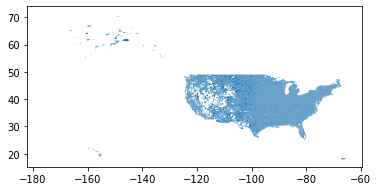

In [28]:
#quick check that data looks OK
gdf.plot()

In [29]:
gdf.set_crs(epsg=4326,inplace=True)
gdf.head(0)

Empty GeoDataFrame
Columns: [ID, total_pop, male_pop, female_pop, pop_25_years_over, median_age, median_income, income_per_capita, gini_index, median_rent, black_pop, hispanic_pop, white_pop, geom, geometry]
Index: []

In [30]:
gdf.to_crs(epsg=5070, inplace=True)

In [31]:
#print(gdf.crs)

In [32]:
#ethnic_groups = ['black_pop', 'hispanic_pop', 'white_pop']

In [33]:
gdf.columns

Index(['ID', 'total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop', 'geom',
       'geometry'],
      dtype='object')

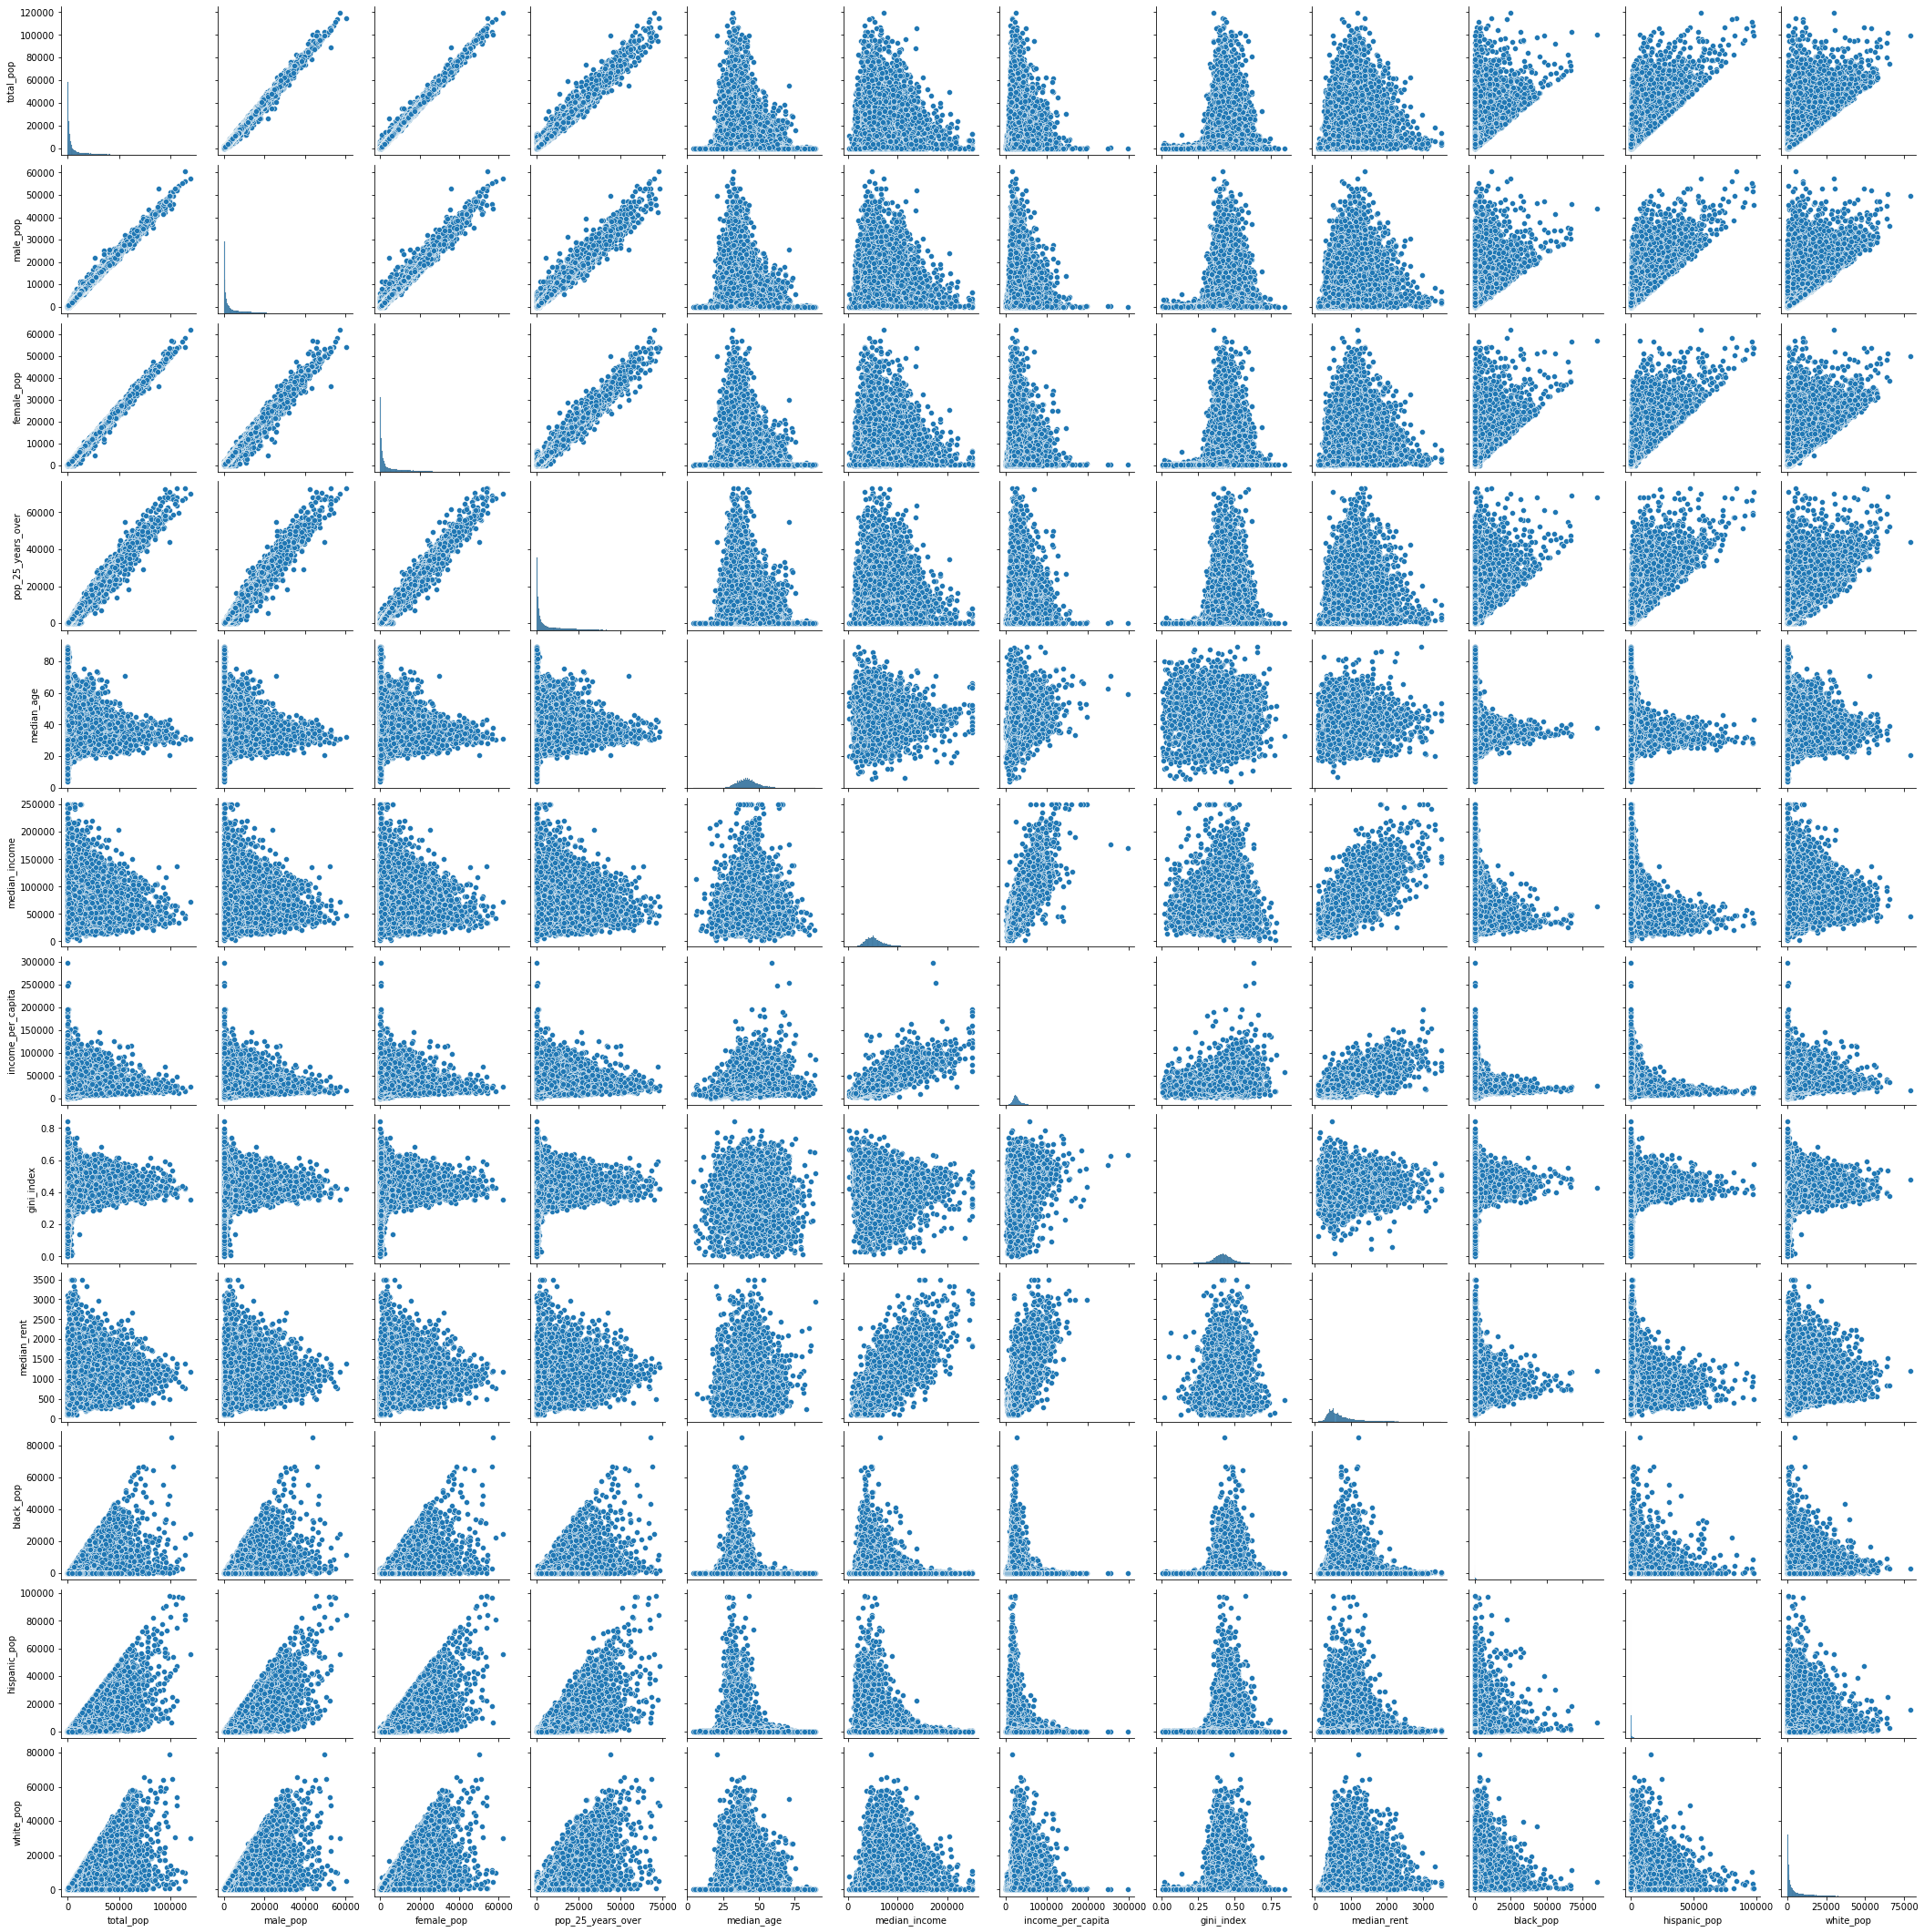

In [34]:
# Create the default pairplot - check if there's any obvious correlation
sns.pairplot(df[['total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']])

In [35]:
cluster_variables =  ['male_pop', 'female_pop', 'pop_25_years_over','median_age', 'median_income', 'income_per_capita',
                      'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']

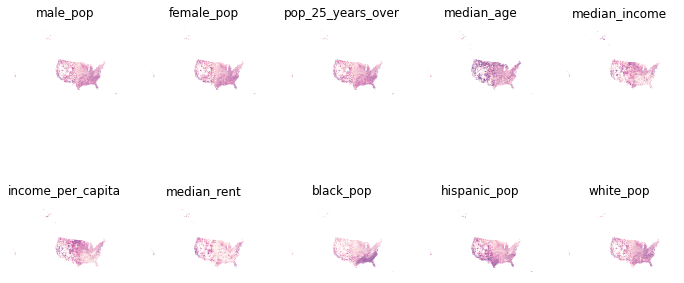

In [36]:
f, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [37]:
# represent the spatial configuration of the data via spatial weights matrix. 
# start with queen contiguity
w = Queen.from_dataframe(gdf)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 332 disconnected components.
 There are 261 islands with ids: 318, 761, 872, 926, 957, 991, 1368, 1583, 1811, 3106, 3919, 4059, 4661, 4722, 5103, 5189, 6255, 6647, 6829, 8051, 8066, 8671, 9118, 9845, 9863, 10792, 10835, 11102, 12065, 12139, 12219, 12844, 12941, 14308, 15182, 15233, 15456, 15533, 16099, 16558, 16948, 17924, 18577, 18643, 18723, 18792, 18862, 18869, 19019, 19029, 19064, 19113, 19359, 19436, 19464, 19540, 19567, 19588, 19605, 19650, 19667, 19682, 19687, 19721, 19812, 19885, 19974, 19996, 20046, 20059, 20088, 20092, 20172, 20214, 20234, 20269, 20300, 20308, 20346, 20402, 20443, 20505, 20508, 20521, 20532, 20537, 20569, 20572, 20581, 20692, 20788, 20795, 20809, 20842, 20844, 20888, 21006, 21068, 21070, 21144, 21159, 21164, 21197, 21248, 21269, 21272, 21306, 21308, 21325, 21335, 21339, 21342, 21416, 21457, 21504, 21545, 2157

In [38]:
#calculate Moran I 
#This will measure the extent to which each variable contains spatial structure:
# Set seed for reproducibility
np.random.seed(123456) 
# Calculate Moran's I for each variable
mi_results = [Moran(gdf[variable], w) for variable in cluster_variables]
# Structure results as a list of tuples 
mi_results = [
    (variable, res.I, res.p_sim) for variable,res in zip(cluster_variables, mi_results)
]
 

('WARNING: ', 318, ' is an island (no neighbors)')
('WARNING: ', 761, ' is an island (no neighbors)')
('WARNING: ', 872, ' is an island (no neighbors)')
('WARNING: ', 926, ' is an island (no neighbors)')
('WARNING: ', 957, ' is an island (no neighbors)')
('WARNING: ', 991, ' is an island (no neighbors)')
('WARNING: ', 1368, ' is an island (no neighbors)')
('WARNING: ', 1583, ' is an island (no neighbors)')
('WARNING: ', 1811, ' is an island (no neighbors)')
('WARNING: ', 3106, ' is an island (no neighbors)')
('WARNING: ', 3919, ' is an island (no neighbors)')
('WARNING: ', 4059, ' is an island (no neighbors)')
('WARNING: ', 4661, ' is an island (no neighbors)')
('WARNING: ', 4722, ' is an island (no neighbors)')
('WARNING: ', 5103, ' is an island (no neighbors)')
('WARNING: ', 5189, ' is an island (no neighbors)')
('WARNING: ', 6255, ' is an island (no neighbors)')
('WARNING: ', 6647, ' is an island (no neighbors)')
('WARNING: ', 6829, ' is an island (no neighbors)')
('WARNING: ', 8051

In [39]:
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

#Most variables display significant positive spatial autocorrelation, suggesting some spatial structure 

Moran's I  P-value
Variable                             
male_pop            0.538255    0.001
female_pop          0.545646    0.001
pop_25_years_over   0.545578    0.001
median_age               NaN    0.001
median_income            NaN    0.001
income_per_capita        NaN    0.001
median_rent              NaN    0.001
black_pop           0.602064    0.001
hispanic_pop        0.650845    0.001
white_pop           0.420449    0.001

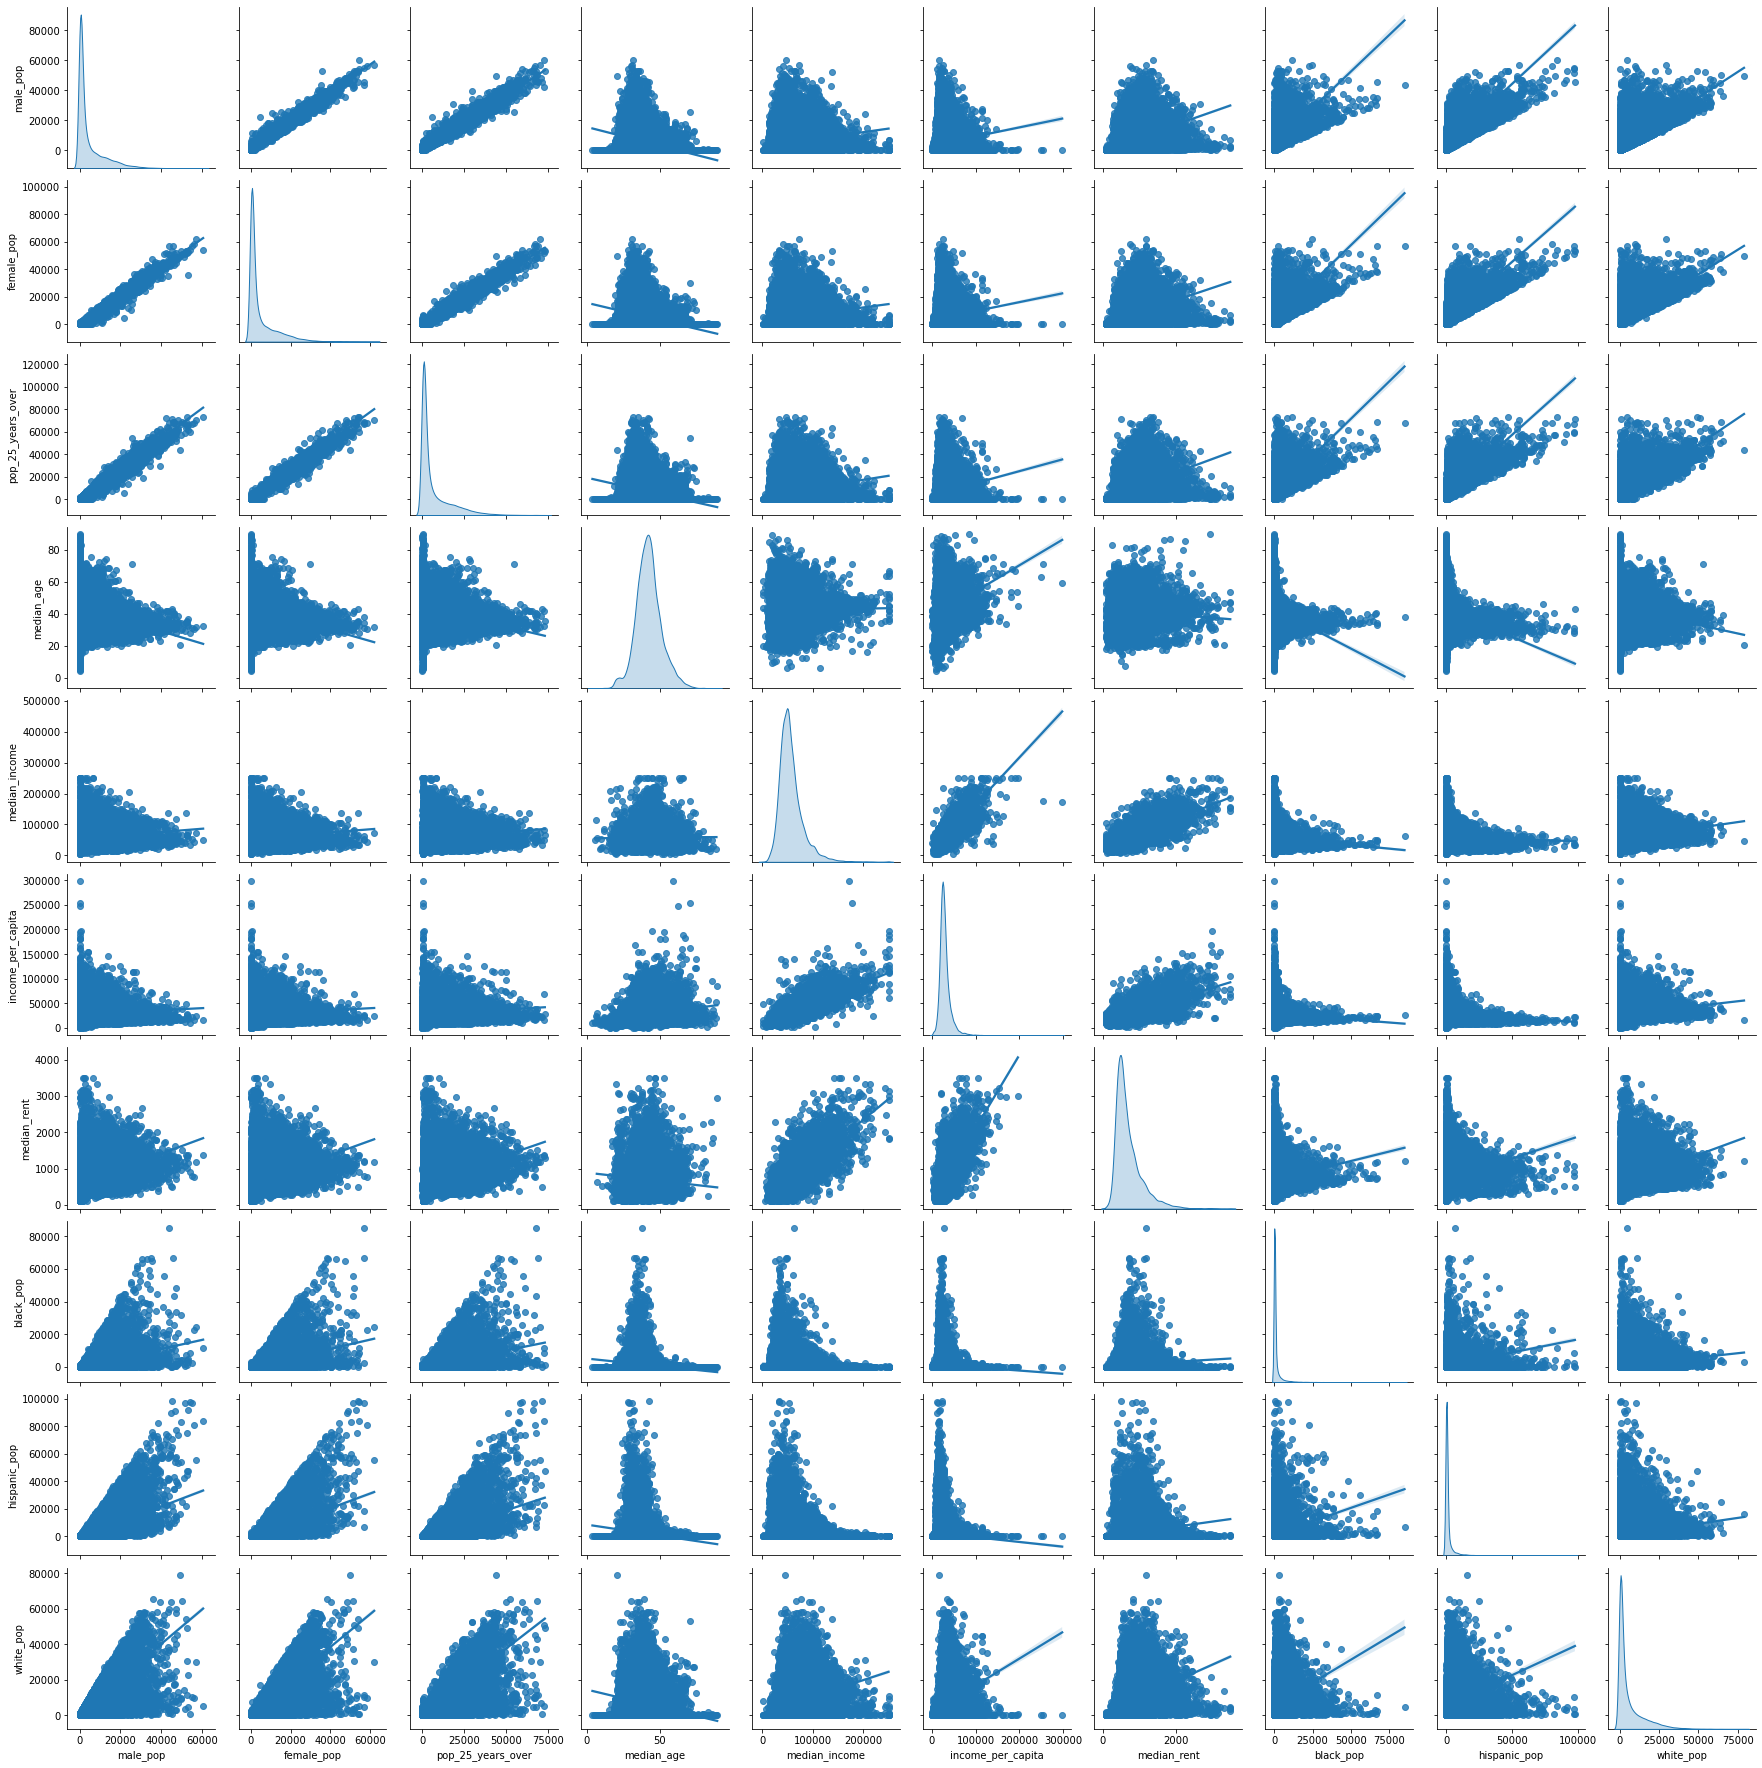

In [40]:
# diagonal elements  are the density functions for the  attributes
_ = sns.pairplot(gdf[cluster_variables], kind='reg', diag_kind='kde')

In [41]:
# Initialise KMeans instance
from sklearn.cluster import KMeans
from sklearn.preprocessing import robust_scale

In [42]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

In [43]:
gdf.isna().sum()

ID                      0
total_pop               0
male_pop                0
female_pop              0
pop_25_years_over       0
median_age            567
median_income        2159
income_per_capita     642
gini_index            907
median_rent          6088
black_pop               0
hispanic_pop            0
white_pop               0
geom                    0
geometry                0
dtype: int64

In [44]:
gdf.dropna(inplace=True)

In [45]:
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
#robust scale to scale the variables

k5cls = kmeans.fit(robust_scale(gdf[cluster_variables]))

In [46]:
k5cls.labels_

array([4, 1, 1, ..., 1, 1, 1])

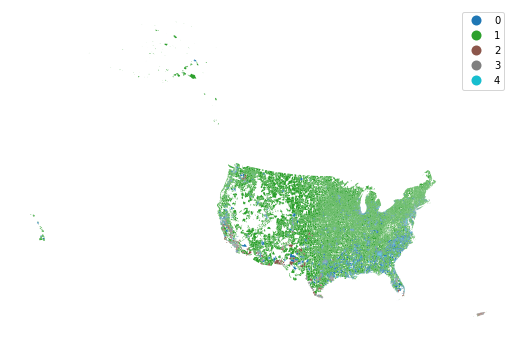

In [47]:
# Assign labels into a column
gdf['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

#### Count observation in each cluster

In [48]:
# Group data table by cluster label and count observations
k5sizes = gdf.groupby('k5cls').size()
k5sizes

k5cls
0     4073
1    20912
2      971
3      279
4      488
dtype: int64

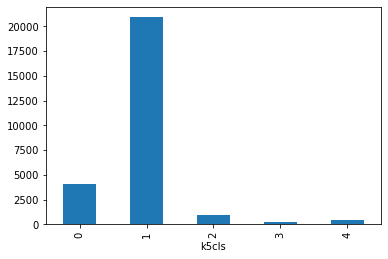

In [49]:
_ = k5sizes.plot.bar()


#### Area/size observations

In [50]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
areas = gdf.dissolve(by='k5cls', aggfunc='sum') 
areas

geometry         ID  \
k5cls                                                                 
0      MULTIPOLYGON (((1571184.820 458024.182, 157073...   34996395   
1      MULTIPOLYGON (((-252446.941 470265.988, -25240...  366500151   
2      MULTIPOLYGON (((3161531.672 -34214.101, 316165...    8438015   
3      MULTIPOLYGON (((3231256.481 -31916.521, 323099...    2407744   
4      MULTIPOLYGON (((1587086.334 469286.007, 158712...    3715284   

       total_pop  male_pop  female_pop  pop_25_years_over  median_age  \
k5cls                                                                   
0      122938197  60187878    62750319           83013904    152365.5   
1      118782537  58904761    59877776           82576753    898814.5   
2       39979308  19866278    20113030           25831850     33532.2   
3       18118683   8921835     9196848           11289375      9318.5   
4       20509337   9640510    10868827           13289748     17169.2   

       median_income  income_per_capita  gini_index  median_rent  black_pop  \
k5cls                                                                         
0       2.547647e+08        130695469.0   1809.9479    3794348.0   16811393   
1       1.183336e+09        607507678.0   8774.6363   13341948.0    5503992   
2       5.183775e+07         23349174.0    429.2868     929507.0    3458483   
3       1.195310e+07          4989975.0    125.4554     241027.0    1215970   
4       2.196146e+07         11219336.0    223.6460     394175.0   12165466   

       hispanic_pop  white_pop  
k5cls                           
0          16322078   76637184  
1           8207031   97793753  
2          19008701   12953927  
3          13537038    2159904  
4           2493949    4606462

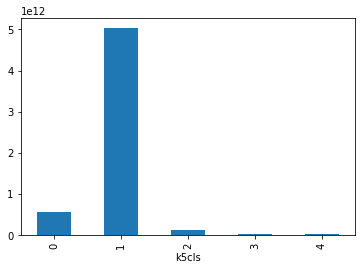

In [51]:
_ = areas.area.plot.bar()

In [52]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = gdf.groupby('k5cls')[cluster_variables].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls                      0          1          2          3          4
male_pop           14777.284   2816.792  20459.607  31977.903  19755.143
female_pop         15406.413   2863.321  20713.728  32963.613  22272.186
pop_25_years_over  20381.513   3948.774  26603.347  40463.710  27233.090
median_age            37.409     42.981     34.534     33.400     35.183
median_income      62549.642  56586.474  53385.942  42842.649  45002.996
income_per_capita  32088.257  29050.673  24046.523  17885.215  22990.443
median_rent          931.586    638.004    957.268    863.896    807.736
black_pop           4127.521    263.198   3561.774   4358.315  24929.234
hispanic_pop        4007.385    392.456  19576.417  48519.849   5110.551
white_pop          18815.906   4676.442  13340.811   7741.591   9439.471

In [53]:
#every row is an observation, and every column is a variable

# Index db on cluster ID
tidy_gdf = gdf.set_index('k5cls')
# Keep only variables used for clustering
tidy_gdf = tidy_gdf[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_gdf = tidy_gdf.stack()
# Take indices into proper columns
tidy_gdf = tidy_gdf.reset_index()
# Rename column names
tidy_gdf =tidy_gdf.rename(
    columns={'level_1': 'Attribute', 0: 'Values'}
)
# Check out result
tidy_gdf.head()

k5cls          Attribute   Values
0      4           male_pop  24123.0
1      4         female_pop  24847.0
2      4  pop_25_years_over  26944.0
3      4         median_age     27.0
4      4      median_income  51972.0

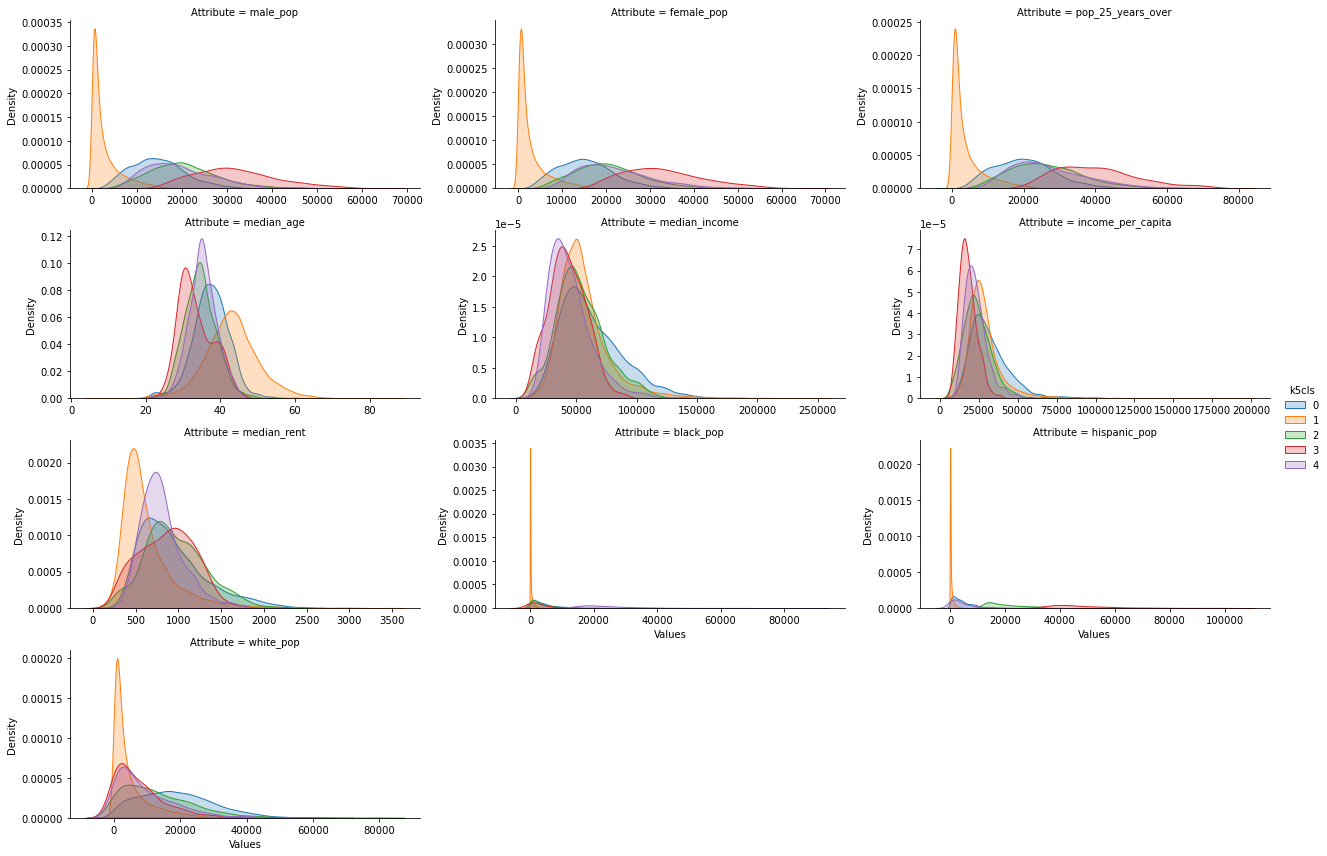

In [54]:
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_gdf,
    col='Attribute',
    hue='k5cls',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

### Hierarchical clustering

In [55]:
from sklearn.cluster import AgglomerativeClustering

Applying a regionalization approach is not always required but it can provide additional insights into the spatial structure of the multivariate statistical relationships that traditional clustering is unable to articulate.

In [56]:
#k-means and Ward’s hierarchical method.
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(robust_scale(gdf[cluster_variables]))
# Assign labels to main data table
gdf['ward5'] =model.labels_

In [57]:
ward5sizes = gdf.groupby('ward5').size()
ward5sizes

ward5
0    23337
1     1592
2      321
3      233
4     1240
dtype: int64

In [58]:
ward5means = gdf.groupby('ward5')[cluster_variables].mean()
ward5means.T.round(3)

ward5                      0          1          2          3          4
male_pop            4096.347  18547.720  31496.720  21580.734  13917.816
female_pop          4193.384  18861.706  32524.034  25003.172  15041.947
pop_25_years_over   5725.390  24381.272  39879.832  30223.270  19136.903
median_age            42.493     34.869     33.316     35.179     36.392
median_income      57979.062  55290.350  43352.720  43484.365  47359.415
income_per_capita  29784.642  25277.918  18175.368  22213.652  25342.670
median_rent          677.613    953.428    874.850    817.785    724.458
black_pop            475.413   3804.921   5534.386  32525.202  10200.203
hispanic_pop         714.032  15104.053  46048.844   4803.481   2386.204
white_pop           6418.094  14011.412   7968.078   7032.429  14411.036

In [59]:
# Index db on cluster ID
tidy_gdf = gdf.set_index('ward5')
# Keep only variables used for clustering
tidy_gdf = tidy_gdf[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_gdf = tidy_gdf.stack()
# Take indices into proper columns
tidy_gdf = tidy_gdf.reset_index()
# Rename column names
tidy_gdf = tidy_gdf.rename(
    columns={'level_1': 'Attribute', 0: 'Values'}
)
# Check out result
tidy_gdf.head()

ward5          Attribute   Values
0      1           male_pop  24123.0
1      1         female_pop  24847.0
2      1  pop_25_years_over  26944.0
3      1         median_age     27.0
4      1      median_income  51972.0

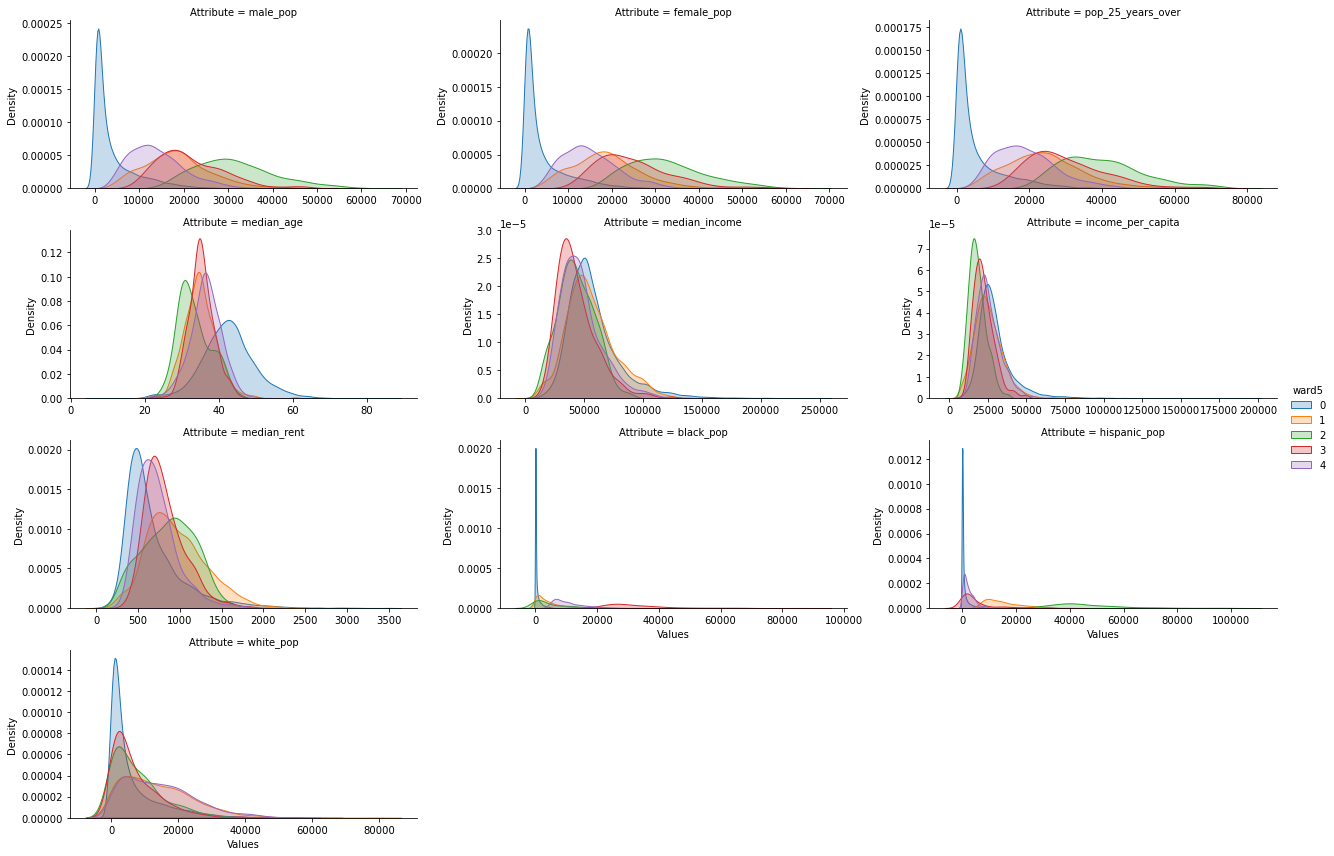

In [60]:
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_gdf,
    col='Attribute',
    hue='ward5',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

Both Kmeans and Agglomerative Clustering  worked in a similar manner

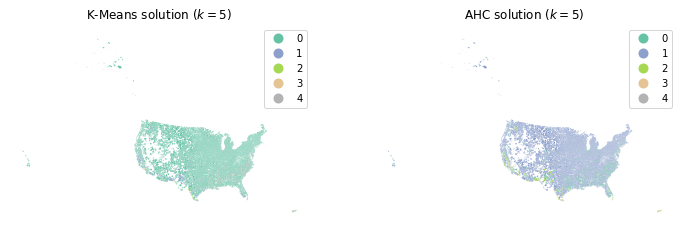

In [61]:
gdf['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

            ### K-Means ###
ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(
    column='ward5', categorical=True, cmap='Set2', legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('K-Means solution ($k=5$)')

            ### AHC ###
ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(
    column='k5cls', categorical=True, cmap='Set2', legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

In [62]:
gdf.to_file('./data/clusters.shp')

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


Kmeans        |  AHC
:-------------------------:|:-------------------------:
    <img src="./images/kmeans5.png" alt="kmeans5" />  |   <img src="./images/ahc5.png" alt="ahc5" />

Fragmented clusters are not  invalid, however, in some cases, the application we are interested in might require that all the observations in a class be spatially connected. 

In [63]:
# KNN where each observation is connected to its four nearest observations, instead of those it touches.

w = KNN.from_dataframe(gdf, k=4)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


In [64]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage='ward', connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(gdf[cluster_variables])

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\sklearn\cluster\_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


AgglomerativeClustering(connectivity=<26723x26723 sparse matrix of type '<class 'numpy.float64'>'
	with 106892 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

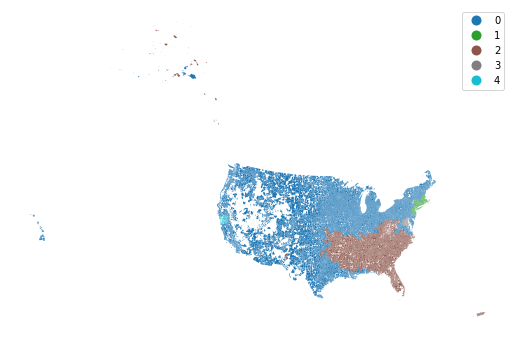

In [65]:
gdf['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

This shows better regionalisation

In [66]:
##goodness of fit

ch_scores = []
for cluster_type in ('k5cls', 'ward5',  'ward5wknn'):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
    # using scaled variables
        robust_scale(gdf[cluster_variables]), 
    # using these labels
        gdf[cluster_type]
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display 
pd.DataFrame(
    ch_scores, 
    columns=['cluster type', 'CH score']
).set_index('cluster type')

CH score
cluster type              
k5cls         18826.721485
ward5         17195.866553
ward5wknn       248.968949

Higher numbers indicate greater fit, whereas functions that end in loss work in the other direction.
 
 

K-means solution has the highest Calinski-Harabasz score, with the ward clustering comes second. The regionalizations with  the improved geographical coherence comes at a  cost in terms of feature goodness of fit. This is because regionalization is constrained, and mathematically can not achieve the same score as the unconstrained K-means solution, unless we get lucky and the k-means solution is a valid regionalization.